In [40]:
import os
import csv
import cv2
import json
import math
from time import time
import matplotlib.pyplot as plt

In [41]:
from vio_ort import VIO

In [58]:
# Инициализация параметров
odometry = VIO(lat0=54.889668, lon0=83.1258973333, alt0=0)
odometry_org = VIO(lat0=54.889668, lon0=83.1258973333, alt0=0)
set_dir = '2024_12_15_15_31_8_num_3'
json_files = sorted([f for f in os.listdir(set_dir) if f.endswith('.json')])
start = 900
count_json = 400

In [59]:
def run_vio(odometry, json_files, start, count_json):
    lat_VIO, lon_VIO, alt_VIO = [], [], []
    for filename in json_files[start:start + count_json]:
        with open(f'{set_dir}/{filename}', 'r') as file:
            data = json.load(file)
            img_path = os.path.join(set_dir, os.path.splitext(filename)[0] + '.jpg')
            image = cv2.imread(img_path)
            result_vio = odometry.add_trace_pt(image, data)
            lat_VIO.append(result_vio['lat'])
            lon_VIO.append(result_vio['lon'])
            alt_VIO.append(result_vio['alt'] * 1000)
    return {
        'lat_VIO': lat_VIO,
        'lon_VIO': lon_VIO,
        'alt_VIO': alt_VIO
    }

In [60]:
def run_vio_gps(odometry, json_files, start, count_json):
    lat_VIO, lon_VIO, alt_VIO = [], [], []
    lat_GPS, lon_GPS, alt_GPS = [], [], []
    for filename in json_files[start:start + count_json]:
        with open(f'{set_dir}/{filename}', 'r') as file:
            data = json.load(file)
            if 'GNRMC' in data and data['GNRMC']['status'] == 'A':
                img_path = os.path.join(set_dir, os.path.splitext(filename)[0] + '.jpg')
                image = cv2.imread(img_path)
                result_vio = odometry.add_trace_pt(image, data)
                lat_VIO.append(result_vio['lat'])
                lon_VIO.append(result_vio['lon'])
                alt_VIO.append(result_vio['alt'] * 1000)
                lat_GPS.append(data['GNRMC'].get('lat', 0.0))
                lon_GPS.append(data['GNRMC'].get('lon', 0.0))
                alt_GPS.append(data['GPS_RAW_INT']['alt'])
    return {
        'lat_VIO': lat_VIO,
        'lon_VIO': lon_VIO,
        'alt_VIO': alt_VIO,
        'lat_GPS': lat_GPS,
        'lon_GPS': lon_GPS,
        'alt_GPS': alt_GPS,
    }

In [61]:
start_time = time()
result = run_vio(odometry, json_files, start, count_json)
elapsed_time = time() - start_time
print(f"time: {elapsed_time:.2f} seconds")

start_time = time()
result_gps = run_vio_gps(odometry, json_files, start, count_json)
elapsed_time = time() - start_time
print(f"time: {elapsed_time:.2f} seconds")

time: 29.32 seconds
time: 28.48 seconds


In [46]:
def transform_vio_coords(vio_lon_list, vio_lat_list, params):
    gps_lon0 = params["gps_lon0"]
    gps_lat0 = params["gps_lat0"]
    vio_lon0 = params["vio_lon0"]
    vio_lat0 = params["vio_lat0"]
    scale_for_lon = params["scale_for_lon"]
    scale_for_lat = params["scale_for_lat"]

    # Для GPS долготы используем VIO широту, для GPS широты — VIO долготу (с инверсией)
    transformed_lon = [(v_lat - vio_lat0) * scale_for_lon + gps_lon0 for v_lat in vio_lat_list]
    transformed_lat = [-(v_lon - vio_lon0) * scale_for_lat + gps_lat0 for v_lon in vio_lon_list]
    return transformed_lon, transformed_lat

In [ ]:
# Шаг 1. Загрузка координат
gps_lat = result_gps['lat_GPS'].copy()
gps_lon = result_gps['lon_GPS'].copy()
vio_lat = result['lat_VIO'].copy()
vio_lon = result['lon_VIO'].copy()

# Шаг 2. Сохраняем начальные точки (они должны совпадать)
gps_lon0 = gps_lon[0]
gps_lat0 = gps_lat[0]
vio_lon0 = vio_lon[0]
vio_lat0 = vio_lat[0]

# Шаг 3. Вычисляем средние изменения (дельты) для последовательностей координат
gps_lon_range = max(gps_lon) - min(gps_lon)
gps_lat_range = max(gps_lat) - min(gps_lat)
vio_lon_range = max(vio_lon) - min(vio_lon)
vio_lat_range = max(vio_lat) - min(vio_lat)

scale_for_lon = gps_lon_range / vio_lat_range  # VIO широта -> GPS долгота
scale_for_lat = gps_lat_range / vio_lon_range  # VIO долгота -> GPS широта

# Шаг 5. Сохраняем параметры трансформации в JSON
transformation_params = {
		"gps_lon0": gps_lon0,
		"gps_lat0": gps_lat0,
		"vio_lon0": vio_lon0,
		"vio_lat0": vio_lat0,
		"scale_for_lon": scale_for_lon,
		"scale_for_lat": scale_for_lat
}

In [ ]:
with open("Debugs/transformation_params.json", "w") as f:
	json.dump(transformation_params, f, indent=4)

In [ ]:
# Сравнение параметров трансформации
diff = {}
for key in transformation_params_new:
    if key in transformation_params and transformation_params[key] != transformation_params_new[key]:
        diff[key] = {
            "old": transformation_params[key],
            "new": transformation_params_new[key]
        }
print("Difference in transformation parameters:")
for key, value in diff.items():
    print(f"{key}: {value['old']} -> {value['new']}")

Difference in transformation parameters:
gps_lon0: 83.1257365 -> 83.1257395
gps_lat0: 54.8894156667 -> 54.889417
scale_for_lon: 2.190223121835729 -> 2.9310191326949755
scale_for_lat: 0.8150111028674851 -> 0.8490131437781521


In [72]:
# Применяем трансформацию к данным оптимизированного варианта
transformed_lon, transformed_lat = transform_vio_coords(
    result['lon_VIO'],  # передаём исходные VIO долготы
    result['lat_VIO'],  # передаём исходные VIO широты
    transformation_params
)

# Обновляем результаты для построения графиков
result['lon_VIO_transformed'] = transformed_lon
result['lat_VIO_transformed'] = transformed_lat

In [73]:
# Применяем трансформацию к данным оптимизированного варианта
transformed_lon_new, transformed_lat_new = transform_vio_coords(
    result['lon_VIO'],  # передаём исходные VIO долготы
    result['lat_VIO'],  # передаём исходные VIO широты
    transformation_params_new
)

# Обновляем результаты для построения графиков
result['lon_VIO_transformed_new'] = transformed_lon_new
result['lat_VIO_transformed_new'] = transformed_lat_new

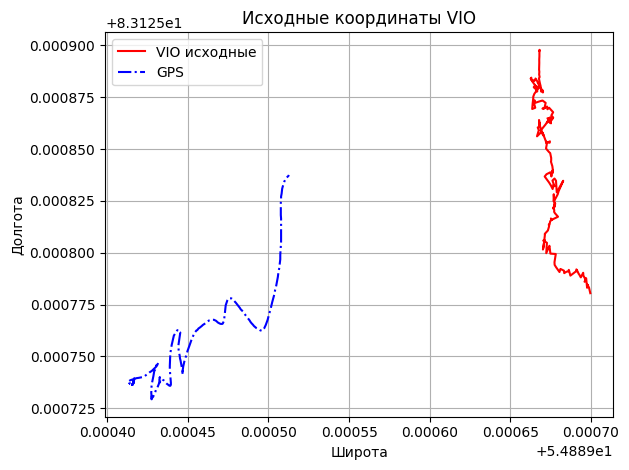

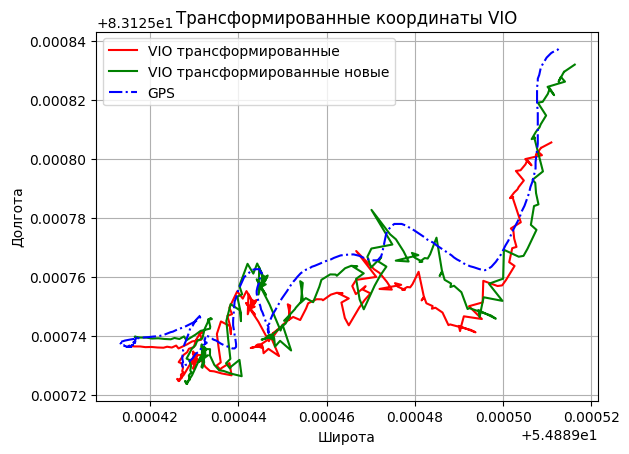

In [74]:
vio_lat = result['lat_VIO']
vio_lon = result['lon_VIO']
vio_lat_transf = result['lat_VIO_transformed']
vio_lon_transf = result['lon_VIO_transformed']
vio_lat_transf_new = result['lat_VIO_transformed_new']
vio_lon_transf_new = result['lon_VIO_transformed_new']

gps_lat = result_gps['lat_GPS']
gps_lon = result_gps['lon_GPS']

# График исходных данных
plt.plot(vio_lat, vio_lon, color="red", label="VIO исходные")
plt.plot(gps_lat, gps_lon, color="blue", linestyle='-.', label="GPS")
plt.xlabel("Широта")
plt.ylabel("Долгота")
plt.title("Исходные координаты VIO")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# График трансформированных данных
plt.plot(vio_lat_transf, vio_lon_transf, color="red", label="VIO трансформированные")
plt.plot(vio_lat_transf_new, vio_lon_transf_new, color="green", label="VIO трансформированные новые")
plt.plot(gps_lat, gps_lon, color="blue", linestyle='-.', label="GPS")
plt.xlabel("Широта")
plt.ylabel("Долгота")
plt.title("Трансформированные координаты VIO")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
